## Download dataset

In [1]:
from dataset import create_dataset,download_dataset
download_dataset()

## Process train_data.parquet, create pytorch files.

In [1]:
import dataset
from dataset import create_dataset,download_dataset
df = dataset.create_dataset()

In [4]:
from converted_dataset import get_converted_dataset, create_pytorch_dataset
create_pytorch_dataset()

100%|██████████| 1728/1728 [06:13<00:00,  4.63it/s]


In [1]:
import torch
from torch_geometric.data import DataLoader,Dataset,Data
import pandas as pd
import numpy as np
import gc
import torch.nn.functional as F
from tqdm import tqdm, trange

train_L = torch.load('./dataset/converted/train.pt',map_location='cuda')
val_L = torch.load('./dataset/converted/val.pt',map_location='cuda')
test_L  = torch.load('./dataset/converted/test.pt',map_location='cuda')

batch_size = 128
dataloaders = {"train":DataLoader(train_L,batch_size=batch_size,shuffle=True),
            "val":DataLoader(val_L,batch_size=batch_size,shuffle=False),
            "test":DataLoader(test_L,batch_size=batch_size),
           }

In [2]:
import torch
from torch_geometric.data import DataLoader,Dataset,Data
import pandas as pd
import numpy as np
import gc
import torch.nn.functional as F
from torch.nn import Embedding, GRU,LSTM,Linear,ReLU, BatchNorm1d,BatchNorm2d,Conv1d, Dropout

class ChallengeModel(torch.nn.Module):
    """ 1D Convolutional Neural Network. """
    NAME = "Conv1d_1"
    
    def __init__(self,max_domain=2000,H1=2*256,H2=2*128,H_emb=16,
                 use_emb=True,**kwargs):
        super(ChallengeModel, self).__init__(**kwargs)
        self.use_emb = use_emb
        self.H_emb = H_emb
        self.max_domain = max_domain
        self.emb = Embedding(max_domain,H_emb)
        self.lin1 = Linear(16,H1)
        self.lin2 = Linear(H1,H2)
        self.bn1 = BatchNorm1d(30)
        self.lin1 = Linear(32,256)
        self.lin2 = Linear(256,128)
        self.lin3 = Linear(128,30)
        self.conv1 = Conv1d(16+ H_emb if use_emb else 16, 32,kernel_size=3)
        self.dr = Dropout(0.5)
        self.conv2 = Conv1d(32, 64,kernel_size=3,stride=2)
        self.conv3 = Conv1d(64, 64,kernel_size=3,stride=2)
        self.conv4 = Conv1d(64, 16,kernel_size=3,stride=2)
        
        
    def forward(self,data,hidden_size=18):
        N, L, H_in = data.X.shape
        
        dom = data.domain.view(-1)
        dom = dom.clip(0,self.max_domain-1).int()
        emb = self.emb(dom).view(data.X.shape[0],data.X.shape[1],self.H_emb)
        
        x = data.X
        x = self.bn1(x)
        #x = F.relu(self.lin1(x))
        #x = F.relu(self.lin2(x))
        if self.use_emb:
            x = torch.cat([x,emb],axis=-1)
        
        x = x.transpose(2,1)
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = x.reshape(N,-1)
        x = self.dr(x)
        x = F.leaky_relu(self.lin1(x))
        x = self.dr(x)
        x = F.leaky_relu(self.lin2(x))
        x = self.lin3(x)
        

        probs = F.softmax(x,dim=1)
        
        return probs
        

class ChallengeModel(torch.nn.Module):
    NAME = "LSTM11"

    def __init__(self,max_domain=8050,H1=256,H2=128,H_emb=32,
                 use_emb=False,**kwargs):
        super(ChallengeModel, self).__init__(**kwargs)
        self.use_emb = use_emb
        self.H_emb = H_emb
        self.max_domain = max_domain
        self.emb = Embedding(max_domain,H_emb)

        self.lin1 = Linear(16,H1)
        self.lin2 = Linear(H1,H2)

        self.lstm = LSTM(input_size= H2 + H_emb if use_emb else H2,
                       hidden_size=32,
                        num_layers=1,
                       batch_first=True)
        self.lin3 = Linear(50,512)
        self.lin4 = Linear(512,30)

    def forward(self,data,hidden_size=18):
        N, L, H_in = data.X.shape
        X  = sample.X[:,:24,:]
        
        
        """ Compute some bonus Features"""
        minutes_active = X[:,:,11].view(N,24)
        minutes_active = torch.cat([torch.ones(N,1),minutes_active.cpu()],axis=1).int()
        days_inactive = torch.max(torch.FloatTensor(minutes_active.numpy()[:,::-1].copy()).cuda(),axis=1)[1]
        items_sold = torch.clip(X[:,:,0].view(N,24),0.,1.)
        items_sold = torch.cat([torch.ones(N,1),items_sold.cpu()],axis=1).int()
        days_no_sold = torch.max(torch.FloatTensor(items_sold.numpy()[:,::-1].copy()).cuda(),axis=1)[1]
        fixed_feats = X[:,0,[2,3,4,5,6,7,8,9,10,13,15]]
        var_feats = X[:,:,[0,1,11,12,14]]
        summ_feats = torch.cat([fixed_feats,var_feats.mean(axis=1),
                                days_inactive.view(-1,1)/30.0,
                                days_no_sold.view(-1,1)/30.0],axis=1)
        
        """ Try to embed the domain id. """
        dom = data.domain.view(-1)
        dom = dom.clip(0,self.max_domain-1).int()
        emb = self.emb(dom).view(data.X.shape[0],data.X.shape[1],self.H_emb)

        x = F.relu(self.lin1(X))
        x = F.relu(self.lin2(x))
        all_outs, (last_output, _) =  self.lstm(x) #(N,L,30)
        
        x = last_output.squeeze(0)
        x = torch.cat([x,summ_feats],axis=-1)
        x = F.relu(self.lin3(x))
        x = self.lin4(x)
        probs = F.softmax(x,dim=1)

        return probs
    
    

import torch.nn as nn
class RNNEncoder(nn.Module):
    def __init__(self, rnn_num_layers=1, input_feature_len=18, sequence_len=30, hidden_size=100, bidirectional=False):
        super().__init__()
        self.sequence_len = sequence_len
        self.hidden_size = hidden_size
        self.input_feature_len = input_feature_len
        self.num_layers = rnn_num_layers
        self.rnn_directions = 2 if bidirectional else 1
        self.gru = nn.GRU(
            num_layers = rnn_num_layers,
            input_size=input_feature_len,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=bidirectional
        )
        
    def forward(self, input_seq):
        ht = torch.zeros(self.num_layers * self.rnn_directions, input_seq.size(0) , self.hidden_size, device='cuda')
        if input_seq.ndim < 3:
            input_seq.unsqueeze_(2)
        gru_out, hidden = self.gru(input_seq, ht)
        if self.rnn_directions > 1:
            gru_out = gru_out.view(input_seq.size(0), self.sequence_len, self.rnn_directions, self.hidden_size)
            gru_out = torch.sum(gru_out, axis=2)
        return gru_out, hidden.squeeze(0)
    
class AttentionDecoderCell(nn.Module):
    def __init__(self, input_feature_len, hidden_size, sequence_len):
        super().__init__()
        # attention - inputs - (decoder_inputs, prev_hidden)
        self.attention_linear = nn.Linear(hidden_size, sequence_len)
        # attention_combine - inputs - (decoder_inputs, attention * encoder_outputs)
        self.decoder_rnn_cell = nn.GRUCell(
            input_size=hidden_size,
            hidden_size=hidden_size,
        )
        self.out = nn.Linear(hidden_size, 1)
        
    def forward(self, encoder_output, prev_hidden, y):
        attention_input = prev_hidden
        attention_weights = F.softmax(self.attention_linear(attention_input)).unsqueeze(1)
        attention_combine = torch.bmm(attention_weights, encoder_output).squeeze(1)
        rnn_hidden = self.decoder_rnn_cell(attention_combine, prev_hidden)
        output = self.out(rnn_hidden)
        return output, rnn_hidden


class EncoderDecoderWrapper(nn.Module):
    NAME = "RNN_And_Att2"
    def __init__(self, encoder, decoder_cell, output_size=30, teacher_forcing=0.3):
        super().__init__()
        self.encoder = encoder
        self.decoder_cell = decoder_cell
        self.output_size = output_size
        self.teacher_forcing = teacher_forcing
        
    def train(self):
        self.encoder.train()
        self.decoder_cell.train()
        
    def eval(self):
        self.encoder.eval()
        self.decoder_cell.eval()
        
    def state_dict(self):
        return {
            'encoder': self.encoder.state_dict(),
            'decoder_cell': self.decoder_cell.state_dict()
        }
    
    def load_state_dict(self, state_dict):
        self.encoder.load_state_dict(state_dict['encoder'])
        self.decoder_cell.load_state_dict(state_dict['decoder_cell'])

    def __call__(self, data):
        xb = data.X.clone()
        yb = None
        input_seq = xb
        encoder_output, encoder_hidden = self.encoder(input_seq)
        prev_hidden = encoder_hidden
        if torch.cuda.is_available():
            outputs = torch.zeros(input_seq.size(0), self.output_size, device='cuda')
        else:
            outputs = torch.zeros(input_seq.size(0), self.output_size)
        y_prev = input_seq[:, -1, :]
        for i in range(self.output_size):
            if (yb is not None) and (i > 0) and (torch.rand(1) < self.teacher_forcing):
                y_prev = yb[:, i].unsqueeze(1)
            rnn_output, prev_hidden = self.decoder_cell(encoder_output, prev_hidden, y_prev)
            y_prev = rnn_output
            outputs[:, i] = rnn_output.squeeze(1)
        return F.softmax(outputs,dim=1)              
        

In [3]:
from tqdm import tqdm,trange
from torch.nn import MSELoss
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import os
NLLLoss = torch.nn.NLLLoss()
def custom_MSE(preds,actuals):
    preds = torch.cumsum(preds,dim=1).float()
    actuals = actuals.float()
    return 30.0*torch.mean(torch.square(preds-actuals))
def XENT(preds,actuals):
    preds = torch.log(preds)
    actuals = torch.argmax(actuals,dim=1)
    return NLLLoss(preds,actuals)

"""
    SELECT YOUR MODEL HERE
"""
enc = RNNEncoder(1,16,30,100).cuda()
dec= AttentionDecoderCell(16,100,30).cuda()
model = EncoderDecoderWrapper(enc,dec)
#model = ChallengeModel().cuda()

writer = SummaryWriter()
num_epochs = 100
opt = torch.optim.Adam(lr=5e-4,params=model.parameters())
step = 0

lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,factor=0.5,patience=100,verbose=True)

torch.cuda.manual_seed(42)
lowest_loss = 9999


batch_size = 128
dataloaders = {"train":DataLoader(train_L,batch_size=batch_size,shuffle=True),
            "val":DataLoader(val_L,batch_size=batch_size,shuffle=False),
            "test":DataLoader(test_L,batch_size=batch_size),
           }


for epoch in range(num_epochs):

    running_loss = {"train":[],"val":[]}
    for mode in ['train','val']:
        if mode == 'train':
                model.train()
        else:
            model.eval()
        for i,sample in tqdm(enumerate(dataloaders[mode]),total=len(dataloaders[mode])):
            out = model(sample)
            loss = custom_MSE(out,sample.target)
            loss_xent = XENT(out,sample.target)
            
            loss_np = loss.clone().detach().cpu().item()
            running_loss[mode].append(loss_np)

            if mode == 'train':
                opt.zero_grad()
                loss_xent.backward()
                opt.step()
        writer.add_scalar(f"Loss/{mode}",  sum(running_loss[mode])/len(running_loss[mode]), step)
        if mode == 'val' and sum(running_loss[mode])/len(running_loss[mode]) < lowest_loss:
            os.makedirs(f'./model/{model.NAME}',exist_ok=True)
            torch.save(model.state_dict(),f'./model/{model.NAME}/best_model.pt')
            lowest_loss = sum(running_loss[mode])/len(running_loss[mode])
            print("New best")

        print(f"Avg loss ({mode}): {sum(running_loss[mode])/len(running_loss[mode])}")

        if mode == 'train':
            step += 1
            torch.cuda.empty_cache()
            writer.flush()
            print("Flushed")
            import os
            os.makedirs(f'./model/{model.NAME}',exist_ok=True)
            if i%50 == 0:
                torch.save(model.state_dict(),f'./model/{model.NAME}/model_{step}.pt')


  0%|          | 0/2586 [00:00<?, ?it/s]<ipython-input-2-e67f319914ba>:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_weights = F.softmax(self.attention_linear(attention_input)).unsqueeze(1)
  3%|▎         | 10/289 [00:00<00:02, 94.24it/s]

Avg loss (train): 3.652901313421068
Flushed


  0%|          | 4/2586 [00:00<01:11, 35.90it/s]

New best
Avg loss (val): 3.496710292195779


  3%|▎         | 10/289 [00:00<00:03, 90.50it/s]

Avg loss (train): 3.5225263421883994
Flushed


  0%|          | 4/2586 [00:00<01:11, 35.89it/s]

Avg loss (val): 3.535823569578283


  3%|▎         | 9/289 [00:00<00:03, 89.02it/s]

Avg loss (train): 3.506158452852696
Flushed


  0%|          | 4/2586 [00:00<01:10, 36.64it/s]

New best
Avg loss (val): 3.477471974481761


  3%|▎         | 9/289 [00:00<00:03, 88.28it/s]

Avg loss (train): 3.4953327621495363
Flushed


  0%|          | 4/2586 [00:00<01:12, 35.84it/s]

Avg loss (val): 3.500893929425408


  3%|▎         | 10/289 [00:00<00:03, 91.67it/s]

Avg loss (train): 3.4855258702678635
Flushed


  0%|          | 4/2586 [00:00<01:11, 36.36it/s]

New best
Avg loss (val): 3.462600800405324


  3%|▎         | 9/289 [00:00<00:03, 89.95it/s]

Avg loss (train): 3.4773926942365074
Flushed


  0%|          | 4/2586 [00:00<01:10, 36.68it/s]

Avg loss (val): 3.4733296884384948


  3%|▎         | 9/289 [00:00<00:03, 89.32it/s]

Avg loss (train): 3.472115393304493
Flushed


  0%|          | 4/2586 [00:00<01:11, 36.13it/s]

New best
Avg loss (val): 3.4496319359974055


  3%|▎         | 9/289 [00:00<00:03, 87.47it/s]

Avg loss (train): 3.46602983126231
Flushed


  0%|          | 4/2586 [00:00<01:10, 36.43it/s]

New best
Avg loss (val): 3.4482466473298916


  3%|▎         | 9/289 [00:00<00:03, 89.32it/s]

Avg loss (train): 3.4614534757898836
Flushed


  0%|          | 4/2586 [00:00<01:12, 35.83it/s]

Avg loss (val): 3.4530019273394945


  3%|▎         | 10/289 [00:00<00:03, 90.72it/s]

Avg loss (train): 3.456699606253026
Flushed


  0%|          | 4/2586 [00:00<01:11, 35.91it/s]

New best
Avg loss (val): 3.439727942423837


  3%|▎         | 9/289 [00:00<00:03, 89.51it/s]

Avg loss (train): 3.4538156360226457
Flushed


  0%|          | 4/2586 [00:00<01:12, 35.45it/s]

Avg loss (val): 3.463597517112547


  3%|▎         | 10/289 [00:00<00:03, 92.70it/s]

Avg loss (train): 3.449124423736578
Flushed


  0%|          | 4/2586 [00:00<01:10, 36.76it/s]

Avg loss (val): 3.4465995577379904


  3%|▎         | 9/289 [00:00<00:03, 88.92it/s]

Avg loss (train): 3.4455667271322734
Flushed


  0%|          | 4/2586 [00:00<01:10, 36.61it/s]

New best
Avg loss (val): 3.4386559250445514


 87%|████████▋ | 2243/2586 [00:55<00:08, 40.65it/s]


KeyboardInterrupt: 

In [4]:
from tqdm import tqdm,trange
from torch.nn import MSELoss
import numpy as np

#model = ChallengeModel().cuda()
model.load_state_dict(torch.load(f'./model/{model.NAME}/best_model.pt'))

for mode in ['val','test']:
    torch.cuda.empty_cache()
    L = []
    model.eval()
    for i,sample in tqdm(enumerate(dataloaders[mode]),
                             total=len(dataloaders[mode]) ):
        out = model(sample)
        L.append(out.clone().detach().cpu())
    L = torch.cat(L,axis=0)
    L = L.cpu().numpy()
    L = np.round(L,decimals=3)
    print(L.shape)
    print(L)    
    import pandas as pd
    out_df = pd.DataFrame(L)
    display(out_df)
    out_df.to_csv(f'./preds/{model.NAME}_{mode}.csv',index=False,header=False)

  0%|          | 0/289 [00:00<?, ?it/s]<ipython-input-2-e67f319914ba>:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_weights = F.softmax(self.attention_linear(attention_input)).unsqueeze(1)
100%|██████████| 289/289 [00:03<00:00, 76.89it/s]


(36938, 30)
[[0.031 0.042 0.043 ... 0.02  0.019 0.019]
 [0.26  0.136 0.101 ... 0.001 0.001 0.001]
 [0.005 0.011 0.018 ... 0.024 0.023 0.021]
 ...
 [0.334 0.295 0.147 ... 0.    0.    0.   ]
 [0.052 0.064 0.064 ... 0.005 0.004 0.004]
 [0.011 0.02  0.027 ... 0.018 0.017 0.015]]


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.031,0.042,0.043,0.042,0.044,0.046,0.047,0.047,0.045,0.043,...,0.027,0.026,0.024,0.023,0.023,0.022,0.021,0.020,0.019,0.019
1,0.260,0.136,0.101,0.094,0.090,0.078,0.057,0.039,0.028,0.021,...,0.002,0.002,0.002,0.002,0.001,0.001,0.001,0.001,0.001,0.001
2,0.005,0.011,0.018,0.027,0.036,0.044,0.047,0.046,0.044,0.042,...,0.035,0.033,0.030,0.028,0.027,0.026,0.025,0.024,0.023,0.021
3,0.353,0.329,0.158,0.075,0.034,0.016,0.007,0.004,0.003,0.002,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
4,0.011,0.026,0.035,0.046,0.062,0.071,0.070,0.063,0.054,0.048,...,0.023,0.021,0.018,0.016,0.015,0.014,0.013,0.012,0.011,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36933,0.002,0.004,0.006,0.009,0.015,0.023,0.033,0.039,0.040,0.038,...,0.045,0.044,0.039,0.034,0.030,0.028,0.028,0.028,0.027,0.025
36934,0.033,0.048,0.053,0.062,0.076,0.082,0.076,0.065,0.054,0.046,...,0.017,0.015,0.013,0.011,0.010,0.009,0.008,0.007,0.007,0.006
36935,0.334,0.295,0.147,0.088,0.057,0.033,0.016,0.008,0.004,0.003,...,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
36936,0.052,0.064,0.064,0.073,0.085,0.088,0.079,0.066,0.054,0.045,...,0.012,0.010,0.009,0.008,0.007,0.006,0.005,0.005,0.004,0.004


  0%|          | 0/4309 [00:00<?, ?it/s]<ipython-input-2-e67f319914ba>:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_weights = F.softmax(self.attention_linear(attention_input)).unsqueeze(1)
100%|██████████| 4309/4309 [00:49<00:00, 87.51it/s]


(551472, 30)
[[0.005 0.011 0.017 ... 0.02  0.018 0.016]
 [0.003 0.008 0.015 ... 0.016 0.015 0.014]
 [0.051 0.175 0.188 ... 0.005 0.004 0.004]
 ...
 [0.004 0.008 0.013 ... 0.035 0.035 0.035]
 [0.022 0.03  0.037 ... 0.023 0.022 0.021]
 [0.001 0.002 0.003 ... 0.062 0.063 0.064]]


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.005,0.011,0.017,0.024,0.035,0.046,0.053,0.053,0.050,0.046,...,0.034,0.031,0.027,0.024,0.022,0.021,0.021,0.020,0.018,0.016
1,0.003,0.008,0.015,0.025,0.041,0.056,0.065,0.065,0.059,0.053,...,0.028,0.025,0.022,0.019,0.018,0.017,0.017,0.016,0.015,0.014
2,0.051,0.175,0.188,0.162,0.114,0.069,0.040,0.025,0.018,0.015,...,0.006,0.006,0.006,0.005,0.005,0.005,0.005,0.005,0.004,0.004
3,0.010,0.024,0.040,0.058,0.078,0.087,0.084,0.074,0.062,0.052,...,0.017,0.015,0.013,0.012,0.011,0.011,0.011,0.010,0.009,0.009
4,0.001,0.003,0.005,0.010,0.017,0.026,0.033,0.036,0.036,0.035,...,0.044,0.041,0.037,0.035,0.035,0.036,0.037,0.035,0.033,0.031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551467,0.004,0.006,0.010,0.015,0.021,0.026,0.030,0.033,0.035,0.037,...,0.040,0.039,0.038,0.038,0.037,0.036,0.036,0.035,0.035,0.035
551468,0.002,0.004,0.007,0.011,0.015,0.020,0.024,0.027,0.029,0.031,...,0.044,0.044,0.044,0.044,0.044,0.043,0.043,0.042,0.042,0.041
551469,0.004,0.008,0.013,0.019,0.025,0.031,0.034,0.037,0.039,0.040,...,0.036,0.036,0.035,0.035,0.035,0.035,0.035,0.035,0.035,0.035
551470,0.022,0.030,0.037,0.043,0.047,0.050,0.049,0.046,0.042,0.039,...,0.030,0.029,0.028,0.027,0.026,0.025,0.024,0.023,0.022,0.021


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.008,0.017,0.023,0.028,0.045,0.052,0.058,0.061,0.054,0.054,...,0.026,0.027,0.018,0.018,0.014,0.017,0.015,0.018,0.009,0.012
1,0.007,0.017,0.024,0.034,0.055,0.064,0.075,0.072,0.060,0.059,...,0.021,0.023,0.015,0.015,0.011,0.014,0.011,0.016,0.008,0.010
2,0.177,0.211,0.165,0.107,0.090,0.066,0.043,0.029,0.019,0.018,...,0.002,0.002,0.002,0.001,0.002,0.001,0.002,0.002,0.001,0.002
3,0.038,0.056,0.064,0.077,0.094,0.106,0.085,0.061,0.061,0.039,...,0.011,0.010,0.008,0.006,0.008,0.009,0.007,0.008,0.004,0.006
4,0.002,0.003,0.006,0.009,0.013,0.020,0.025,0.035,0.028,0.039,...,0.044,0.043,0.037,0.034,0.027,0.036,0.037,0.037,0.037,0.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551467,0.006,0.010,0.009,0.015,0.015,0.026,0.026,0.025,0.022,0.025,...,0.047,0.044,0.048,0.034,0.038,0.046,0.055,0.052,0.047,0.050
551468,0.006,0.009,0.008,0.014,0.014,0.024,0.024,0.023,0.019,0.024,...,0.048,0.045,0.048,0.036,0.039,0.047,0.059,0.055,0.049,0.054
551469,0.008,0.013,0.013,0.019,0.021,0.032,0.034,0.028,0.034,0.031,...,0.040,0.041,0.047,0.027,0.036,0.042,0.035,0.039,0.037,0.034
551470,0.018,0.023,0.025,0.033,0.038,0.054,0.053,0.042,0.053,0.042,...,0.030,0.031,0.035,0.018,0.021,0.028,0.020,0.024,0.022,0.019


In [1]:

#import tweedie
L = []
model.eval()
for i,sample in tqdm(enumerate(dataloaders['train']),
                         total=len(dataloaders['train']) ):
    out = model(sample)
    temp = sample.target.clone().detach().cpu()
    L.append(np.argmax(temp,axis=1))
    
L = torch.cat(L)
L = L.cpu().numpy()


fig, ax = plt.subplots(figsize=(10,5))
ax.hist(L,bins=30)
ax.set_xticks(np.arange(31))
ax.grid()
fig.show()
#L = np.round(L,decimals=3)


NameError: name 'model' is not defined

<ipython-input-10-c53536396de8>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


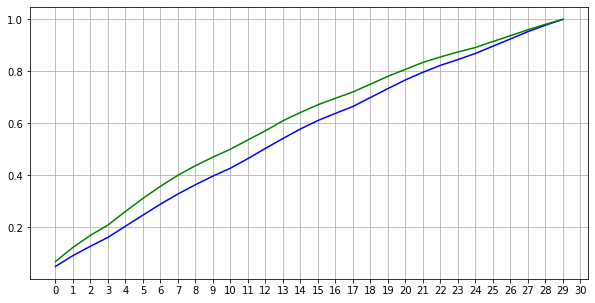

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xticks(np.arange(31))
ax.grid()
fig.show()
df1 = pd.read_csv('./ensemble.csv.gz',header=None)


val_labels = torch.cat([el.target.view(-1,30) for el in torch.load('./dataset/converted/val.pt',map_location='cuda')],
                 axis=0).cpu().numpy()

plt.plot(np.arange(30),np.mean(df1.values.cumsum(axis=1),axis=0),c='blue')

plt.plot(np.arange(30),np.mean(val_labels,axis=0),c='green')
#df = pd.read_csv('./LSTM2.csv.gz',header=None)
#ax.plot(np.arange(30),np.mean(df.values,axis=0),c='red')
#fig.show()

In [21]:
import pandas as pd
df1 = pd.read_csv('./LSTM1.csv.gz',header=None)
display(df1)
df2 = pd.read_csv('./LSTM2.csv.gz',header=None)

df3 = pd.read_csv('./LSTM3_1.csv.gz',header=None)


df = pd.DataFrame(np.round( (df1.values+df2.values+df3.values)/3, decimals=4))
df.to_csv(f'./LSTM_1+2+3.csv.gz',index=False,header=False,compression='gzip')

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.005,0.006,0.011,0.015,0.026,0.037,0.046,0.051,0.041,0.045,...,0.037,0.034,0.027,0.024,0.024,0.024,0.022,0.023,0.020,0.016
1,0.005,0.009,0.015,0.021,0.036,0.054,0.060,0.068,0.051,0.053,...,0.031,0.026,0.020,0.018,0.017,0.017,0.016,0.013,0.013,0.010
2,0.214,0.186,0.155,0.102,0.093,0.053,0.042,0.024,0.018,0.017,...,0.004,0.002,0.002,0.003,0.001,0.001,0.002,0.001,0.001,0.001
3,0.042,0.046,0.064,0.062,0.088,0.096,0.075,0.062,0.056,0.046,...,0.015,0.012,0.009,0.010,0.007,0.009,0.008,0.005,0.007,0.005
4,0.006,0.006,0.010,0.012,0.021,0.026,0.035,0.035,0.036,0.037,...,0.042,0.039,0.036,0.032,0.029,0.033,0.031,0.034,0.028,0.027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551467,0.006,0.005,0.007,0.010,0.013,0.014,0.022,0.021,0.027,0.024,...,0.048,0.046,0.045,0.043,0.042,0.048,0.049,0.054,0.047,0.047
551468,0.006,0.005,0.007,0.010,0.014,0.014,0.022,0.021,0.027,0.024,...,0.047,0.045,0.045,0.043,0.042,0.048,0.049,0.054,0.048,0.047
551469,0.007,0.007,0.008,0.012,0.016,0.016,0.025,0.023,0.029,0.026,...,0.045,0.044,0.043,0.041,0.041,0.046,0.046,0.050,0.045,0.044
551470,0.016,0.017,0.021,0.023,0.030,0.032,0.040,0.038,0.037,0.037,...,0.035,0.035,0.032,0.032,0.032,0.032,0.031,0.031,0.029,0.027


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df1 = pd.read_csv('./LSTM1.csv.gz',header=None)


NameError: name 'test_L' is not defined

<ipython-input-6-347d70b127ae>:107: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


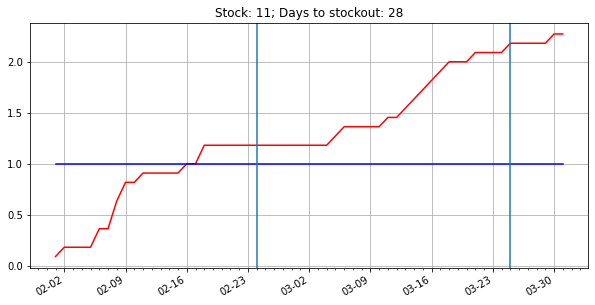

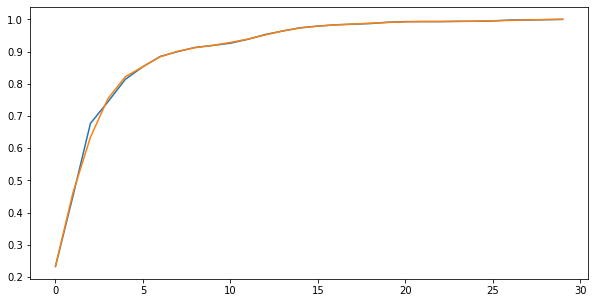

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

skus = pd.read_csv('./dataset/test_data.csv')

skus = skus['sku']

sku = skus[2256]

df2 = pd.read_csv('./preds/Lightgbm_3_test.csv',header=None)
def sep_train_val(df,validation_mode=0):
    train_init = pd.to_datetime('2021-02-01T00:00:00.000000000')
    val_init = pd.to_datetime('2021-02-25T00:00:00.000000000')

    is_train =  (pd.to_datetime(df['date']) - train_init).dt.days < 24
    is_val = ~is_train & (( pd.to_datetime(df['date']) - val_init ).dt.days < 30)
    train = df[is_train].copy()
    val = df[is_val].copy()
    val['days_passed'] =  (pd.to_datetime(df['date']) - val_init).dt.days
    val['cumsum'] = val['sold_quantity'].cumsum()
    #print(df)
    #print(train.shape,val.shape,val['cumsum'].values[0],val['cumsum'].values[-1])
    if (train.shape[0]==0) or (not val.shape[0] == 30) or (val['cumsum'].values[0] ==val['cumsum'].values[-1]):
        """
            Useless sample for validation. Return some other (hopefully good sample instead)
        """
        raise ""

    if df['stock'].values[0] < 0 or validation_mode == 0:
        """ We take the last day with nonzero sold quantity.
            Then, the stock is the amount of items sold from the 
            beginning of the validation month till this day.
        """
        days_to_stockout = int(val[val['sold_quantity']>0]\
                            ['days_passed'].values[-1])
        stock = (val['cumsum'].values[-1] - val['cumsum'].values[0])
    elif validation_mode == 1:
        """ The stock is the same as given in the test data. If our
            task in the test data is to predict how long till x units of
            product y are sold, then we count how many days in the validation
            month it took to produce that amount.
        """
        stock = df['stock'].values[0]
        if val[val['cumsum']>=stock].shape[0] == 0:
            days_to_stockout=-1
        else:
            days_to_stockout = int(val[val['cumsum']>=stock]\
                                ['days_passed'].values[0])
    
    
    return train, val, stock, days_to_stockout

df_sku = df[df['sku']==sku]
df_sku_train, df_sku_val,stock, days_to_stockout = sep_train_val(df_sku)


import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(10,5))

# Major ticks every 6 months.
fmt_half_year = mdates.DayLocator(interval=7)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.DayLocator(interval=1)
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# Format the coords message box, i.e. the numbers displayed as the cursor moves
# across the axes within the interactive GUI.
ax.grid(True)
fig.autofmt_xdate()
#ax.grid()
ax.plot(df_sku['date'],df_sku['sold_quantity'].cumsum()/stock,c='red')

ax.plot(df_sku['date'],df_sku['minutes_active'],c='blue')
ax.axvline(df_sku_train['date'].values[-1])
ax.axvline(df_sku_val[df_sku_val['cumsum']>=stock]['date'].values[0])
ax.set_title(f"Stock: {stock}; Days to stockout: {days_to_stockout}")
fig.show()

df2['sku'] = skus
fig, ax = plt.subplots(figsize=(10,5))
x = np.arange(30)
y = np.round(df2[df2['sku']==sku].values[0,:-1],decimals=3).cumsum()
yhat = savitzky_golay(y, 7, 2) # window size 51, polynomial order 3
ax.plot(x,y)
ax.plot(x,yhat)


In [17]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')




out_df = pd.read_csv('./LSTM_1+2.csv.gz',header=None)
display(out_df)
for i in range(len(out_df.shape)):
    out_df.iloc[i,:] = np.round(savitzky_golay(out_df.iloc[i,:].values, 7, 2),decimals=4)
display(out_df)

out_df.to_csv('./LSTM_1+2_smoothed.csv.gz',header=None,index=None,compression='gzip')

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0130,0.0125,0.0210,0.0265,0.0390,0.0525,0.0475,0.0595,0.0485,0.0480,...,0.0300,0.0260,0.0230,0.0190,0.0185,0.0195,0.0180,0.0200,0.0155,0.0135
1,0.0100,0.0130,0.0215,0.0280,0.0430,0.0580,0.0570,0.0665,0.0500,0.0540,...,0.0270,0.0220,0.0200,0.0165,0.0150,0.0170,0.0150,0.0140,0.0130,0.0115
2,0.1860,0.2390,0.1575,0.1150,0.0965,0.0525,0.0345,0.0185,0.0145,0.0130,...,0.0030,0.0025,0.0015,0.0020,0.0015,0.0010,0.0015,0.0010,0.0010,0.0010
3,0.0315,0.0360,0.0500,0.0545,0.0850,0.0935,0.0775,0.0730,0.0600,0.0435,...,0.0180,0.0120,0.0120,0.0085,0.0080,0.0090,0.0100,0.0075,0.0080,0.0060
4,0.0050,0.0065,0.0085,0.0135,0.0205,0.0265,0.0325,0.0380,0.0365,0.0350,...,0.0435,0.0370,0.0345,0.0300,0.0280,0.0340,0.0320,0.0315,0.0290,0.0250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551467,0.0050,0.0050,0.0065,0.0080,0.0105,0.0115,0.0170,0.0175,0.0200,0.0240,...,0.0495,0.0500,0.0435,0.0505,0.0435,0.0525,0.0500,0.0605,0.0460,0.0690
551468,0.0055,0.0055,0.0070,0.0085,0.0115,0.0120,0.0175,0.0180,0.0205,0.0245,...,0.0495,0.0480,0.0420,0.0500,0.0430,0.0510,0.0500,0.0585,0.0480,0.0655
551469,0.0065,0.0075,0.0080,0.0105,0.0135,0.0150,0.0210,0.0210,0.0225,0.0265,...,0.0485,0.0480,0.0400,0.0460,0.0415,0.0495,0.0500,0.0540,0.0485,0.0565
551470,0.0130,0.0145,0.0170,0.0195,0.0250,0.0290,0.0345,0.0340,0.0325,0.0375,...,0.0365,0.0425,0.0330,0.0370,0.0325,0.0385,0.0360,0.0350,0.0305,0.0340


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0127,0.0153,0.0194,0.0295,0.0385,0.0479,0.0532,0.0533,0.0505,0.0501,...,0.0329,0.0272,0.0217,0.0201,0.0186,0.0188,0.0190,0.0177,0.0158,0.0156
1,0.0100,0.0144,0.0203,0.0315,0.0425,0.0546,0.0600,0.0603,0.0545,0.0521,...,0.0295,0.0238,0.0185,0.0171,0.0161,0.0155,0.0152,0.0141,0.0127,0.0124
2,0.1860,0.2390,0.1575,0.1150,0.0965,0.0525,0.0345,0.0185,0.0145,0.0130,...,0.0030,0.0025,0.0015,0.0020,0.0015,0.0010,0.0015,0.0010,0.0010,0.0010
3,0.0315,0.0360,0.0500,0.0545,0.0850,0.0935,0.0775,0.0730,0.0600,0.0435,...,0.0180,0.0120,0.0120,0.0085,0.0080,0.0090,0.0100,0.0075,0.0080,0.0060
4,0.0050,0.0065,0.0085,0.0135,0.0205,0.0265,0.0325,0.0380,0.0365,0.0350,...,0.0435,0.0370,0.0345,0.0300,0.0280,0.0340,0.0320,0.0315,0.0290,0.0250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551467,0.0050,0.0050,0.0065,0.0080,0.0105,0.0115,0.0170,0.0175,0.0200,0.0240,...,0.0495,0.0500,0.0435,0.0505,0.0435,0.0525,0.0500,0.0605,0.0460,0.0690
551468,0.0055,0.0055,0.0070,0.0085,0.0115,0.0120,0.0175,0.0180,0.0205,0.0245,...,0.0495,0.0480,0.0420,0.0500,0.0430,0.0510,0.0500,0.0585,0.0480,0.0655
551469,0.0065,0.0075,0.0080,0.0105,0.0135,0.0150,0.0210,0.0210,0.0225,0.0265,...,0.0485,0.0480,0.0400,0.0460,0.0415,0.0495,0.0500,0.0540,0.0485,0.0565
551470,0.0130,0.0145,0.0170,0.0195,0.0250,0.0290,0.0345,0.0340,0.0325,0.0375,...,0.0365,0.0425,0.0330,0.0370,0.0325,0.0385,0.0360,0.0350,0.0305,0.0340
